# **Deep learning for dynamic network analysis (DLDNA)** <br> Final project

**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI

Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

### **1. Preliminnary tasks**

**Import of the libraries**

In [48]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings to keep notebook clean

import random
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import sys
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset

**Path configuration**

In [49]:
PROJECT_ROOT = Path.cwd().parent.resolve()
DATA_DIR= PROJECT_ROOT / "data"
PARAM_FILE = PROJECT_ROOT / "txt" / "parameters.txt"
# utils.py functions
UTILS_DIR = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_ROOT / "src"))
from utils import load_parameters, load_and_pre_process_images
from visualization import show_soil_grid

**Choose the good torch device**

In [50]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'xpu' if hasattr(torch, "xpu") and torch.xpu.is_available() else 'cpu'
print(f"Params loaded. Device: {DEVICE}")

Params loaded. Device: cuda


**General parameters**

In [51]:
# Load parameters from external file
params = load_parameters(PARAM_FILE)
globals().update(params)
soil_types = params["SOIL_TYPES"].split(",")


Loaded parameters:
  TRAIN_RATIO = 0.7
  VAL_RATIO = 0.1
  TEST_RATIO = 0.2
  BATCH_SIZE = 64
  EPOCHS = 100
  LEARNING_RATE = 0.01
  SEED = 42
  SOIL_TYPES = Alluvial_Soil,Arid_Soil,Black_Soil,Laterite_Soil,Mountain_Soil,Red_Soil,Yellow_Soil


**Seeding to ensure reproducibility**

In [52]:
# Use parameters for seed and device
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

**Load the dataset**

In [ ]:
# Load and preprocess images once using the new utility
images_dict = {}
for soil in soil_types:
    folder = DATA_DIR / "Orignal-Dataset" / soil
    # Resize/Crop defaults are fine; set standardize=True to avoid later normalization
    images = load_and_pre_process_images(folder, target_size=128)
    images_dict[soil] = images
    print(f"{soil}: {len(images)} images loaded and preprocessed")

Alluvial_Soil: 52 images loaded and preprocessed


KeyboardInterrupt: 

**Display the first pictures of each type of soil**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4076548..5.536454].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1236136..2.1600456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2632368..5.103174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5842297..4.274538].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4431543..3.1796317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6435328..4.342107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.705939..3.

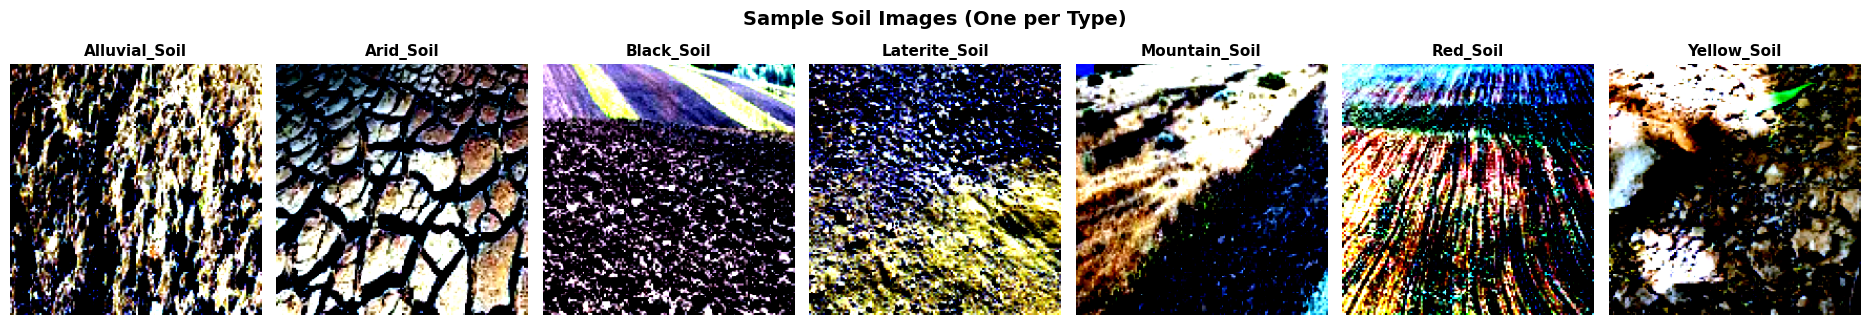

In [ ]:
# images_dict = {soil_type: [(img_bgr, filename), ...], ...}
show_soil_grid(images_dict, n_per_type=5, tile_size=(240, 240), pad=12)

**Create Results folder to store the results**

In [ ]:
# Create results folder structure
from pathlib import Path

results_root = (Path('..') / 'results').resolve()
subfolders = ['CNN', 'GAN', 'StarGAN', 'Attention']

results_root.mkdir(parents=True, exist_ok=True)
for name in subfolders:
    (results_root / name).mkdir(parents=True, exist_ok=True)

print(f"Created/verified results root: {results_root}")
for name in subfolders:
    print(f" - {results_root / name}")

Created/verified results root: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results
 - C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\CNN
 - C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\GAN
 - C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\StarGAN
 - C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\results\Attention


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        # First convolutional layer: 3 input channels -> 32 output channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        # Second convolutional layer: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Third convolutional layer: 64 -> 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layer: reduces spatial dimensions by 2 each time
        self.pool = nn.MaxPool2d(2)

        # Adaptive pooling: makes the feature map always 1x1 (independent of input size)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: 128 pooled features -> 128
        self.fc1 = nn.Linear(128, 128)

        # Dropout to reduce overfitting
        self.drop = nn.Dropout(0.3)

        # Output layer: 128 -> 7 classes
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        # First conv block: conv -> relu -> pool
        x = self.pool(F.relu(self.conv1(x)))

        # Second conv block: conv -> relu -> pool
        x = self.pool(F.relu(self.conv2(x)))

        # Third conv block: conv -> relu -> pool
        x = self.pool(F.relu(self.conv3(x)))

        # Global average pooling: (batch, 128, H, W) -> (batch, 128, 1, 1)
        x = self.gap(x)

        # Flatten: (batch, 128, 1, 1) -> (batch, 128)
        x = x.view(x.size(0), -1)

        # FC + relu + dropout
        x = self.drop(F.relu(self.fc1(x)))

        # Output (CrossEntropyLoss applies softmax internally)
        return self.fc2(x)


In [ ]:
# Normalization is already handled in load_and_pre_process_images(standardize=True)
# Keep images_dict as the source for subsequent steps.
# No additional per-channel normalization here to avoid double normalization.

In [ ]:
all_images = []
all_labels = []
for soil_type, images in images_dict.items():
    for img, filename in images:
        all_images.append(img)
        all_labels.append(soil_type)

X_temp, X_test, y_temp, y_test = train_test_split(all_images, all_labels, test_size=TEST_RATIO, random_state=SEED, stratify=all_labels)
relative_val_ratio = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=relative_val_ratio, random_state=SEED, stratify=y_temp)

print(f"Dataset split: train ({len(X_train)}), val ({len(X_val)}), test ({len(X_test)})")

Dataset split: train (832), val (119), test (238)


In [ ]:
class SoilDataset(Dataset):
    def __init__(self, images, labels):
        self.data = images
        self.labels = labels
        unique_labels = sorted(list(set(labels)))
        self.soil_type_to_idx = {soil_type: idx for idx, soil_type in enumerate(unique_labels)}
        self.label_indices = [self.soil_type_to_idx[label] for label in labels]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):         
        img = self.data[idx]
        img = np.transpose(img, (2, 0, 1))
        img_tensor = torch.FloatTensor(img)
        label = self.label_indices[idx]
        return img_tensor, label

train_dataset = SoilDataset(X_train, y_train)
val_dataset = SoilDataset(X_val, y_val)
test_dataset = SoilDataset(X_test, y_test)
print(f"Datasets created - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Datasets created - Train: 832, Val: 119, Test: 238


In [ ]:
model = SimpleCNN().to(DEVICE)  # Create model and move to device

loss_fn = nn.CrossEntropyLoss()  # Binary Cross Entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)  # Adam optimizer using weight decay which helps regularization in order to reduce overfitting
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Test with our blueprint model
from util_2 import inspect_architecture
inspect_architecture(model, "SimpleCNN")


=== SimpleCNN Architecture Inspection ===
 2. conv1                | Conv2d          | Params:      896
 3. conv2                | Conv2d          | Params:    18496
 4. conv3                | Conv2d          | Params:    73856
 5. pool                 | MaxPool2d       | Params:        0
 6. gap                  | AdaptiveAvgPool2d | Params:        0
 7. fc1                  | Linear          | Params:    16512
 8. drop                 | Dropout         | Params:        0
 9. fc2                  | Linear          | Params:      903
Total Parameters: 110,663
Trainable Parameters: 110,663
Non-trainable Parameters: 0


110663

In [ ]:
def train_with_validation(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=100):
    """Train the model with validation monitoring and save best checkpoint."""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()  # Reset gradients
            preds = model(xb)      # Forward pass
            loss = loss_fn(preds, yb)  # Compute loss
            loss.backward()        # Backward pass
            optimizer.step()       # Update weights using the gradients

            train_loss += loss.item()
            correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)

        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += loss_fn(preds, yb).item()
                correct += (preds.argmax(dim=1) == yb).sum().item()
                total += yb.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:03d} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}"
            )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            # Save best model checkpoint to ../model/best_model
            from pathlib import Path
            model_dir = (Path('..') / 'model').resolve()
            model_dir.mkdir(parents=True, exist_ok=True)
            save_path = model_dir / 'best_model'
            torch.save(best_state, save_path)
            print(f"Saved new best model to: {save_path}")

    if best_state is not None:
        model.load_state_dict(best_state)
    
    return model, train_losses, val_losses, train_accs, val_accs

In [ ]:
model, train_losses, val_losses, train_accs, val_accs = train_with_validation(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=DEVICE,
    epochs=EPOCHS
)

Epoch 001 | Train Loss: 2.1799 Acc: 0.234 | Val Loss: 1.8464 Acc: 0.235
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Epoch 010 | Train Loss: 1.8130 Acc: 0.233 | Val Loss: 1.8005 Acc: 0.235
Epoch 020 | Train Loss: 1.8090 Acc: 0.243 | Val Loss: 1.8046 Acc: 0.235
Epoch 030 | Train Loss: 1.8084 Acc: 0.246 | Val Loss: 1.8046 Acc: 0.235
Epoch 040 | Train Loss: 1.8072 Acc: 0.238 | Val Loss: 1.8018 Acc: 0.235
Epoch 050 | Train Loss: 1.8098 Acc: 0.245 | Val Loss: 1.8042 Acc: 0.235
Epoch 060 | Train Loss: 1.8084 Acc: 0.239 | Val Loss: 1.8051 Acc: 0.235
Epoch 070 | Train Loss: 1.8085 Acc: 0.239 | Val Loss: 1.8046 Acc: 0.235
Epoch 080 | Train Loss: 1.8105 Acc: 0.239 | Val Loss: 1.8056 Acc: 0.235
Epoch 090 | Train Loss: 1.8082 Acc: 0.239 | Val Loss: 1.8027 Acc: 0.235
Epoch 100 | Train Loss: 1.8084 Acc: 0.239 | Val Loss: 1.8089 Acc: 0.235


In [ ]:
def test_model(model, test_loader, loss_fn, device):
    """
    Perform final testing on the model using the held-out test set.
    """
    model.eval()
    test_loss = 0.0
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            # Forward pass
            logits = model(xb)

            # Accumulate loss
            test_loss += loss_fn(logits, yb).item()

            all_logits.append(logits)
            all_labels.append(yb)

    test_loss /= len(test_loader)
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    return test_loss, all_logits, all_labels


In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loss, logits, labels = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=loss_fn,
    device=DEVICE
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

preds = torch.argmax(logits, dim=1).cpu().numpy()
labels = labels.cpu().numpy()

accuracy  = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average="weighted", zero_division=0)
recall    = recall_score(labels, preds, average="weighted", zero_division=0)
f1        = f1_score(labels, preds, average="weighted", zero_division=0)

print("=" * 50)
print("TEST SET RESULTS - CNN")
print("=" * 50)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("=" * 50)


TEST SET RESULTS - CNN
Accuracy : 0.2395
Precision: 0.0574
Recall   : 0.2395
F1-score : 0.0926


NameError: name 'cm' is not defined

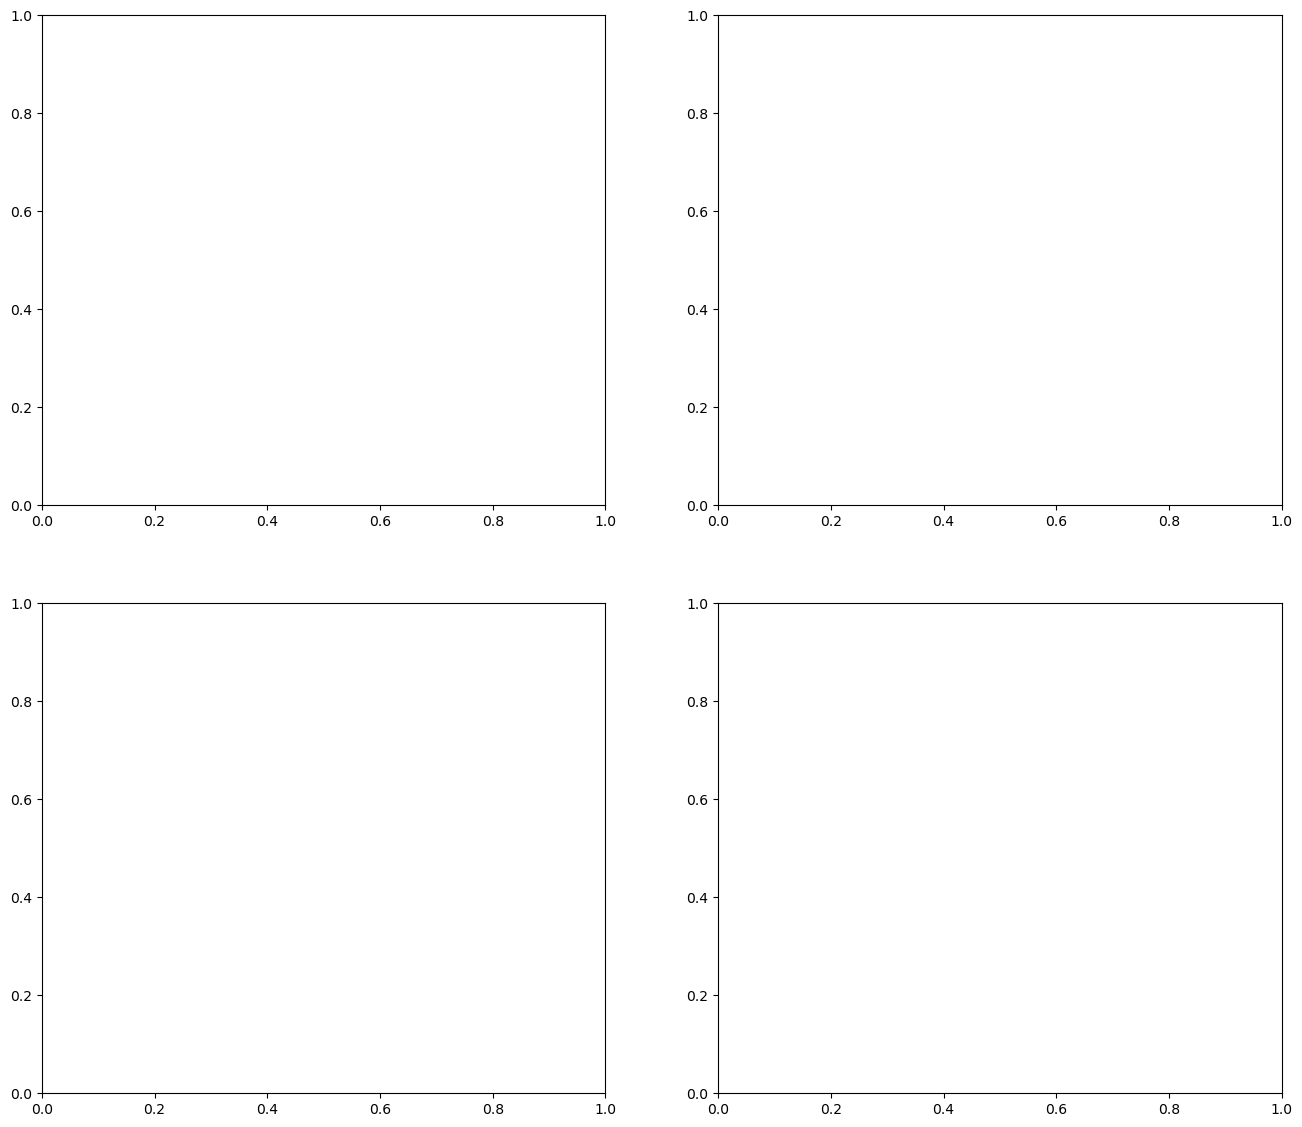

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enhanced Confusion Matrix Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Raw Confusion Matrix (Counts)
ax = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - Raw Counts', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 2. Normalized Confusion Matrix (Percentages by True Class) - safe division
row_sums = cm.sum(axis=1, keepdims=True)
cm_normalized = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0) * 100

ax = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
ax.set_title('Confusion Matrix - Normalized (% per True Class)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 3. Correct Predictions Heatmap (Diagonal Only)
cm_correct = np.zeros_like(cm, dtype=float)
for i in range(len(soil_types)):
    cm_correct[i, i] = cm[i, i]

ax = axes[1, 0]
sns.heatmap(cm_correct, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Correct Predictions'})
ax.set_title('Correct Predictions per Class', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# 4. Per-Class Accuracy Bar Chart - safe division
class_totals = cm.sum(axis=1)
class_accuracies = np.divide(np.diag(cm), class_totals, out=np.zeros_like(class_totals, dtype=float), where=class_totals != 0) * 100

colors = ['#2ecc71' if acc >= 70 else '#f39c12' if acc >= 50 else '#e74c3c' for acc in class_accuracies]
ax = axes[1, 1]
bars = ax.bar(soil_types, class_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

mean_acc = np.mean(class_accuracies) if len(class_accuracies) else 0.0
ax.axhline(y=mean_acc, color='blue', linestyle='--', linewidth=2, label=f'Mean Accuracy: {mean_acc:.1f}%')

ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Soil Type', fontsize=11, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=12, fontweight='bold')
ax.set_ylim([0, 105])
ax.set_xticklabels(soil_types, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed accuracy summary
print("\n" + "="*70)
print("DETAILED ACCURACY ANALYSIS")
print("="*70)
for i, soil_type in enumerate(soil_types):
    correct = int(cm[i, i])
    total = int(cm[i].sum())
    accuracy = (correct / total * 100) if total > 0 else 0.0
    print(f"{soil_type:20s}: {correct:3d}/{total:3d} = {accuracy:6.2f}%")
print("="*70)


In [ ]:
# Save results to GAN folder
print("\nSaving results to GAN folder...\n")

results_dir = Path('..') / 'results' / 'CNN'
results_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
import torch
import torch.nn as nn

# --- 1. CONFIGURATION DE L'ESPACE DE RECHERCHE OPTIMISÉE ---
learning_rates = [1e-3, 5e-4, 1e-4]
dropout_options = [0.3, 0.4, 0.5]
weight_decay_options = [1e-5, 1e-4]

def grid_search_hyperparameters(
    train_loader,
    val_loader,
    learning_rates,
    dropout_options,
    weight_decay_options,
    device,
    epochs=10,
    model_fn=None,
    save_path="best_model.pth",
):
    """
    Recherche par grille sur le taux d'apprentissage, le dropout et le weight decay.
    """
    assert model_fn is not None, "Fournir model_fn(dropout) -> nn.Module"

    results = []           # Stocke tous les résultats
    best_val_acc = -1.0    # Suivi de la meilleure précision
    best_cfg = None        # Suivi de la meilleure configuration
    best_state = None      # Suivi des meilleurs poids du modèle

    for lr in learning_rates:
        for dropout in dropout_options:
            for wd in weight_decay_options:
                print(f"\n>>> Test en cours : lr={lr}, dropout={dropout}, weight_decay={wd}")

                # Création du modèle avec le dropout spécifique
                model = model_fn(dropout).to(device)

                # Optimiseur avec weight decay
                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=lr,
                    weight_decay=wd
                )

                # Fonction de perte
                loss_fn = nn.CrossEntropyLoss()

                # Entraînement du modèle
                # (Assurez-vous que la fonction train_with_validation est définie dans votre script)
                model, train_losses, val_losses, train_accs, val_accs = train_with_validation(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device,
                    epochs=epochs
                )

                cur_best_val = max(val_accs)  # Meilleure précision sur cette session

                # Enregistrement des résultats
                results.append({
                    'lr': lr,
                    'dropout': dropout,
                    'weight_decay': wd,
                    'best_val_acc': cur_best_val,
                    'final_train_acc': train_accs[-1],
                    'final_val_acc': val_accs[-1]
                })

                print(f"Meilleure précision Val : {cur_best_val:.4f}")

                # Mise à jour du meilleur modèle global
                if cur_best_val > best_val_acc:
                    best_val_acc = cur_best_val
                    best_cfg = {'lr': lr, 'dropout': dropout, 'weight_decay': wd}
                    best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

                    if save_path is not None:
                        torch.save(best_state, save_path)
                        print(f"Nouveau meilleur modèle sauvegardé sous : {save_path}")

                # Libération de la mémoire
                del model
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    # Reconstruction du meilleur modèle final
    best_model = None
    if best_state is not None:
        best_model = model_fn(best_cfg['dropout']).to(device)
        best_model.load_state_dict(best_state)

    return results, best_cfg, best_model

# --- 2. EXÉCUTION ---

# IMPORTANT : Remplacez 'VotreClasseModel' par le nom de votre classe de réseau neurones
# La fonction lambda permet d'injecter la variable 'dropout' dans votre classe.
results, best_cfg, best_model = grid_search_hyperparameters(
    train_loader=train_loader,
    val_loader=val_loader,
    learning_rates=learning_rates,
    dropout_options=dropout_options,
    weight_decay_options=weight_decay_options,
    device=DEVICE,
    epochs=100,
    model_fn=lambda d: SimpleCNN(dropout_rate=d), 
    save_path="best_model.pth",
)


>>> Test en cours : lr=0.01, dropout=0.0, weight_decay=0.0
Epoch 001 | Train Loss: 1.9715 Acc: 0.209 | Val Loss: 1.8116 Acc: 0.235
Saved new best model to: C:\Users\alera\Desktop\ENTPE\Deep Learning\Project\model\best_model
Epoch 010 | Train Loss: 1.8158 Acc: 0.234 | Val Loss: 1.8069 Acc: 0.235
Epoch 020 | Train Loss: 1.8135 Acc: 0.220 | Val Loss: 1.8047 Acc: 0.235
Epoch 030 | Train Loss: 1.8126 Acc: 0.239 | Val Loss: 1.8080 Acc: 0.235
Epoch 040 | Train Loss: 1.8085 Acc: 0.240 | Val Loss: 1.8068 Acc: 0.235
Epoch 050 | Train Loss: 1.8088 Acc: 0.236 | Val Loss: 1.8055 Acc: 0.235
Epoch 060 | Train Loss: 1.8073 Acc: 0.239 | Val Loss: 1.8067 Acc: 0.235
Epoch 070 | Train Loss: 1.8115 Acc: 0.237 | Val Loss: 1.8058 Acc: 0.235
Epoch 080 | Train Loss: 1.8110 Acc: 0.237 | Val Loss: 1.8001 Acc: 0.235
Epoch 090 | Train Loss: 1.8083 Acc: 0.237 | Val Loss: 1.8031 Acc: 0.235
Epoch 100 | Train Loss: 1.8078 Acc: 0.239 | Val Loss: 1.8092 Acc: 0.235
Meilleure précision Val : 0.2353
Nouveau meilleur modèl

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid_search(results):
    df = pd.DataFrame(results)
    # On crée une table pivot pour la heatmap (LR vs Dropout)
    pivot_table = df.pivot_table(index='lr', columns='dropout', values='best_val_acc')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
    plt.title('Accuracy selon le Learning Rate et le Dropout')
    plt.show()

# Après ton grid search :
# plot_grid_search(results)